# Options and Black-Scholes Model

### This notebook demostrated how to calibrate Black-Scholes model with real-world data

## 1. Price an option

__Consider a call option__
$$ dS_t = \mu S_t dt+\sigma S_t dW_t $$
$$ S_t = S_0 \cdot exp(\mu t + \sigma W_t) $$

__Denote $F$ as the payoff at expiration $T$__
$$ F_t = B_t \cdot E_Q [B{_T^{-1}} F|\mathcal{F}_t]$$

__With Black-Scholes we explicitly have $F_t$ :__
$$f(t,S_t) = S_t \Phi(d_{+})-K \cdot exp(-r\tau) \Phi(d_{-})$$
$$d_{\pm} = \frac{1}{\sigma \sqrt{\tau}} ln (\frac{S_t}{K})+(r \pm \frac{\sigma^2}{2})\frac{\sqrt{\tau}}{\sigma}$$

__With Put-Call parity: __
$$ C(t) -P(t) = S_t - B{_T^{-1}}K$$

__Let's find the $\mu, \sigma,r$, and other parameters!__

* Prepare the tools

In [8]:
import numpy as np #Handle math objects like vectors and matrixs
from scipy.stats import norm # Normal cdf is used
import pandas as pd #Contains data from yahoo
import matplotlib.pyplot as plt # Seeing is believing! --Thrall
from datetime import datetime # Very usefull when you need to operate on date
from datetime import timedelta # Very usefull when you need to operate on date
from yahoo_finance import Share # API from Yahoo to fetch data
%matplotlib inline

* Choose a stock.

In [9]:
equity = Share('SPY')

Here equity is an object instance with a lots of methods to extract data from yahoo finance

In [39]:
i = datetime.now()
j = i - timedelta(days=(63+4))

currentDate = "%s-%s-%s"%(i.year,i.month,i.day)
startDate = "%s-%s-%s"%(j.year,j.month,j.day)

* Fetch historical data

In [40]:
data = equity.get_historical(startDate,currentDate)

_data_ is a list of dictionaries which contains infos more than just price. Take a look.

In [41]:
data[0:3]

[{'Adj_Close': '235.539993',
  'Close': '235.539993',
  'Date': '2017-03-29',
  'High': '235.809998',
  'Low': '234.729996',
  'Open': '234.990005',
  'Symbol': 'SPY',
  'Volume': '53156500'},
 {'Adj_Close': '235.320007',
  'Close': '235.320007',
  'Date': '2017-03-28',
  'High': '235.809998',
  'Low': '233.139999',
  'Open': '233.270004',
  'Symbol': 'SPY',
  'Volume': '93483900'},
 {'Adj_Close': '233.619995',
  'Close': '233.619995',
  'Date': '2017-03-27',
  'High': '233.919998',
  'Low': '231.610001',
  'Open': '231.929993',
  'Symbol': 'SPY',
  'Volume': '87454500'}]

_data_ is very well organized. Pandas.DataFrame is the perfect tool to convert this list into a table.

In [42]:
df = pd.DataFrame(data)
df.index = df.Date
df.drop('Date',1,inplace = True)
# df.set_value('2017-03-27',['Adj_Close','Close','High','Low','Open','Symbol','Volume'],[4.60,4.60,4.65,4.51,4.55,'RAD',8040000])
df.sort_index(inplace = True) # ,ascending = False
df.head()

,Adj_Close,Close,High,Low,Open,Symbol,Volume
Date,,,,,,,
2017-01-23,225.170405,226.149994,226.809998,225.270004,226.740005,SPY,75061600
2017-01-24,226.614136,227.600006,228.080002,226.270004,226.399994,SPY,95555300
2017-01-25,228.575604,229.570007,229.570007,228.509995,228.699997,SPY,84437700
2017-01-26,228.336639,229.330002,229.710007,229.009995,229.399994,SPY,59970700
2017-01-27,227.978197,228.970001,229.589996,228.759995,229.419998,SPY,59711100


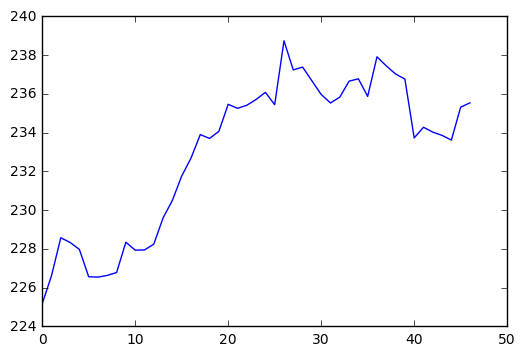

In [43]:
plt.plot(df.Adj_Close.values)

__Unfortunely, Yahoo sent us the data as strings! (WHY?!!?)__


In [44]:
type(df.Adj_Close.values[1])

str

Convert strings to numerics:

In [45]:
numCol = ['Adj_Close','Close','High','Low','Open','Volume']

for col in numCol:
    df[col] = pd.to_numeric(df[col])

In [46]:
type(df.Adj_Close.values[1])

numpy.float64

Compute the log return

In [47]:
df['logReturn'] = np.log(1+df.Adj_Close.diff(1)/df.Adj_Close)
df.fillna(0,inplace = True)

In [85]:

sigma = np.sqrt(np.var(df[['logReturn']].values)*252)
mu = np.mean(df[['logReturn']].values)*252+0.5*sigma**2
print(mu,sigma)

0.238666682006 0.0706813669425


LIBOR is 1.16% and other parameters

$\Delta$

In [49]:
r = 0.0116
# expires at July 17
tau = 116/252
K = 235
S = df['Adj_Close'].loc['2017-03-27']
call_True = 5.5

* Write a Black-Scholes function

In [93]:
def BS(vec):
    r,sigma,tau,K,S = vec
    B = np.exp(r*tau)
    dp = 1/(sigma*np.sqrt(tau))*np.log(S/K)+(r+(sigma**2)/2)*(np.sqrt(tau)/sigma)
    dm = dp - sigma*np.sqrt(tau)
    call = S*norm.cdf(dp)-(K/B)*norm.cdf(dm)
    put = call - (S-(K/B))
    delta = norm.cdf(dp)
    gamma = norm.pdf(dp)/(sigma*np.sqrt(tau)*S)
    return(call,put,delta,gamma)

In [64]:
options = [{"Strike":230,
          "Call":8.74,
           "Put":5.62},
         {"Strike":235,
          "Call":5.5,
          "Put":7.14},
         {"Strike":240,
          "Call":2.97,
          "Put":9.79}]
options_df = pd.DataFrame(options)
options_df['Date']  = '2017-03-27'
options_df = options_df[['Date','Strike','Call','Put']]
options_df

,Date,Strike,Call,Put
0,2017-03-27,230,8.74,5.62
1,2017-03-27,235,5.50,7.14
2,2017-03-27,240,2.97,9.79


In [563]:
#r,sigma,tau,K,S = vec

In [100]:
call,put,delta,gamma = BS([r,sigma,tau,K,S])

print(call,put,delta,gamma)

4.40627956113 4.53480339391 0.504990086896 0.035606756555


In [77]:
BS([r,sigma,tau,options_df.loc[index,'Strike'],S])

(7.2607032117060157, 2.4158543033659328, 0.6775918143320081)

$\bar{X}$
$\sqrt{11111111}$

In [81]:
for index in options_df.index:
    BSCall,BSPut,BSDelta = BS([r,sigma,tau,options_df.loc[index,'Strike'],S])
    options_df.set_value(index,['BS-Call','BS-Put'],[BSCall,BSPut])
    
options_df

,Date,Strike,Call,Put,BS-Call,BS-Put
0,2017-03-27,230,8.74,5.62,7.260703,2.415854
1,2017-03-27,235,5.50,7.14,4.406280,4.534803
2,2017-03-27,240,2.97,9.79,2.417594,7.519490


## 2. Implied Vol and Vol Smile

Here we solve for the implied vol numerically, formally solving this:

$$ min_\sigma ||BS(\sigma)-Call^{*}||{_2^2}$$

Where $Call^*$ is the vector of actual call prices.

* Write a line-search function to find Implied Vol Numerically so that we can call it to get the vol smile later

In [53]:
def IV(vec):
    r,tau,K,S,call = vec
    error = []
    sigmaList = (pd.Series(range(0,4000))+1)/2000 #search from 0 to 2.0
    for sigma in sigmaList:
        error.append((BS([r,sigma,tau,K,S])[0]-call)**2)
    loc = np.argmin(error)
    return(sigmaList[loc])

In [56]:
print(IV([r,tau,K,S,call_True])*100,'%')

8.8 %


This result is __not close__ to the one provided by Optionshouse.com (12.74%) or fintools.com (10.94%)

Now we loop through an options chain to get vol smile:

In [57]:
strikeList = pd.Series(range(210,260,5)).tolist()
callList = [25.48,20.94,16.58,12.47,8.74,5.50,2.97,1.32,0.50,0.185]

n = len(callList)

In [60]:
print(strikeList)
print(callList)

[210, 215, 220, 225, 230, 235, 240, 245, 250, 255]
[25.48, 20.94, 16.58, 12.47, 8.74, 5.5, 2.97, 1.32, 0.5, 0.185]


In [58]:
volList = list(map(lambda ind: IV([r,tau,strikeList[ind],S,callList[ind]]), list(range(n))))

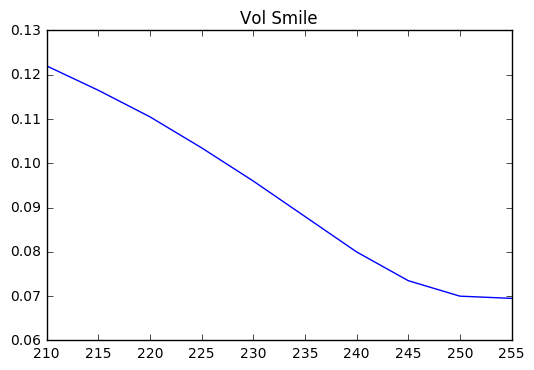

In [59]:
plt.plot(strikeList,volList)
plt.savefig('SPY_vol_smile_03-27.png')
plt.title("Vol Smile")

Estimate the impact of stock price change to the option prices:

From Taylor expansion, we have:\\
$$\Delta F = \nabla_S F \cdot \Delta S + \epsilon$$
To make more accurate estimate, we can utilize the second-order information:
$$\Delta F = \nabla_S F \cdot \Delta S +\frac{1}{2}\nabla^2_S F \cdot \Delta^2 S + \epsilon$$
$$\Delta =  \Phi(d+)$$
$$\Gamma = \phi(d+) \frac{1}{\sigma \sqrt{\tau}S}$$

With only first order method

In [102]:
S1 = 236.235
dS = S1 - S
dC_hat = dS*delta
dC_True = 6.90-call_True
print('Call price change estimated by delta is %.2f' % dC_hat)
print('True Call price change is %.2f' % dC_True)

Call price change estimated by delta is 1.32
True Call price change is 1.40


With second-order information

In [103]:
dC_hat = dS*delta+0.5*gamma*(dS**2)
print('Call price change estimated by delta is %.2f' % dC_hat)
print('True Call price change is %.2f' % dC_True)

Call price change estimated by delta is 1.44
True Call price change is 1.40
